# Extraction

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import morphology, io
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches 
from scipy import ndimage as ndi
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 8.0)

d:\users\asus\appdata\local\programs\python\python37\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
def alternateSequentialFiltering(image):
    # ASF(alternate sequential filtering) Smooth the whole picture
    open1 = cv2.morphologyEx(image, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)), iterations=1)
    close1 = cv2.morphologyEx(open1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)), iterations=1)
    open2 = cv2.morphologyEx(close1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13)), iterations=1)
    close2 = cv2.morphologyEx(open2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13)), iterations=1)
    open3 = cv2.morphologyEx(close2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21)), iterations=1)
    close3 = cv2.morphologyEx(open3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21)), iterations=1)
    return close3

def preProcess(i):
    image = cv2.imread('training/images/'+str(i)+'_training.tif')
    g = image[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_g_fundus = clahe.apply(g)
    R3 = alternateSequentialFiltering(contrast_g_fundus)
    
    plt.subplot(1,3,1)
    plt.imshow(g, cmap="gray")
    cv2.imwrite('./image/greenchannel/'+str(i)+'_bloodvessel.png', g)
    
    plt.subplot(1,3,2)
    plt.imshow(contrast_g_fundus, cmap="gray")
    cv2.imwrite('./image/clahe/'+str(i)+'_bloodvessel.png', contrast_g_fundus)
    
    plt.subplot(1,3,3)
    plt.imshow(R3, cmap="gray")
    cv2.imwrite('./image/filtering/'+str(i)+'_bloodvessel.png', R3)
    plt.show()

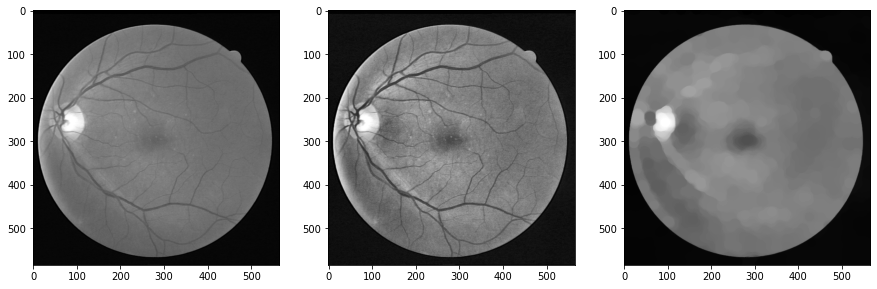

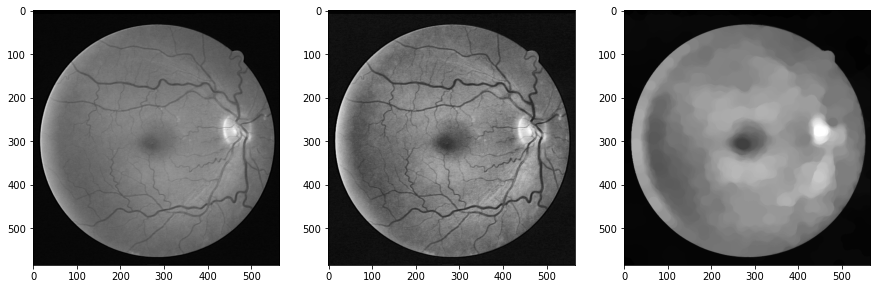

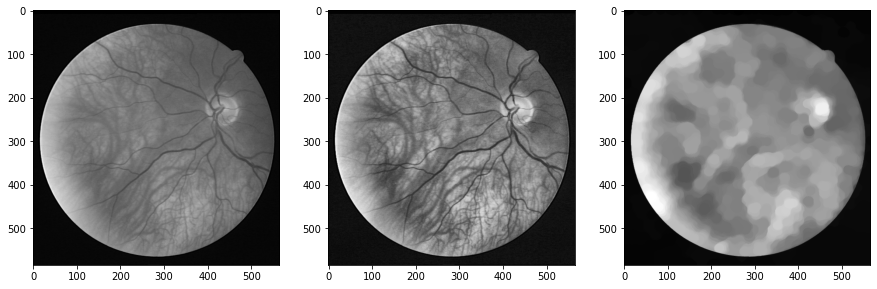

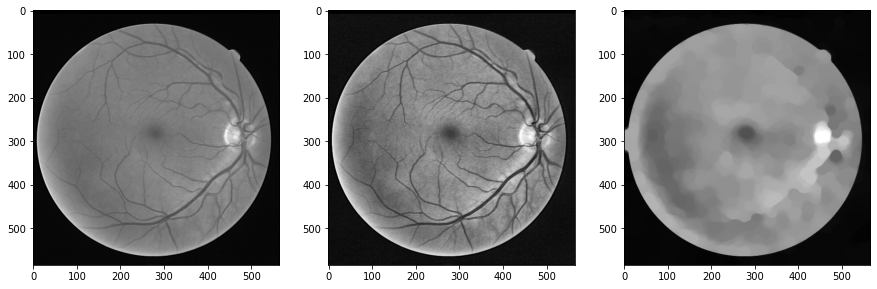

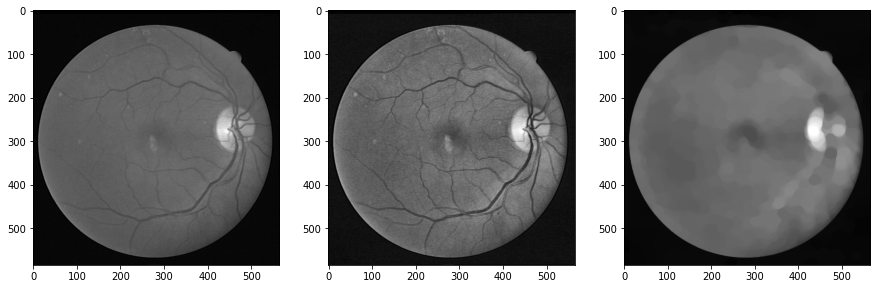

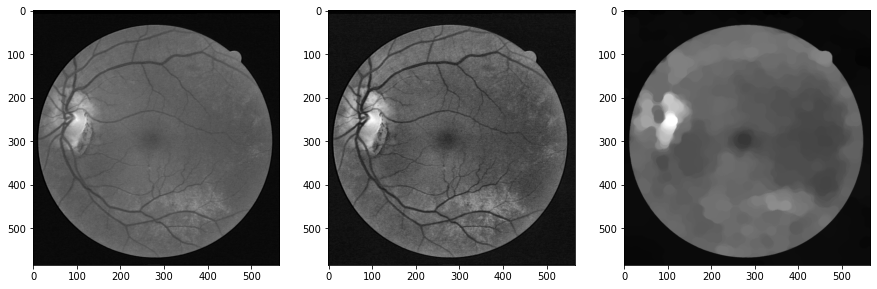

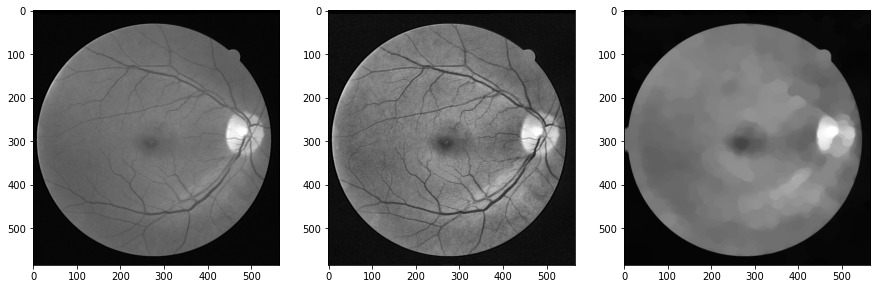

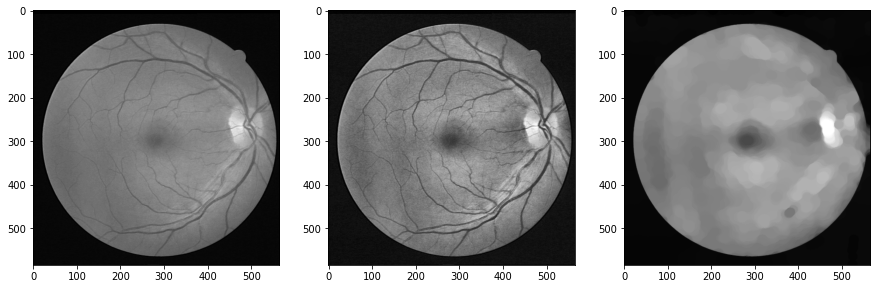

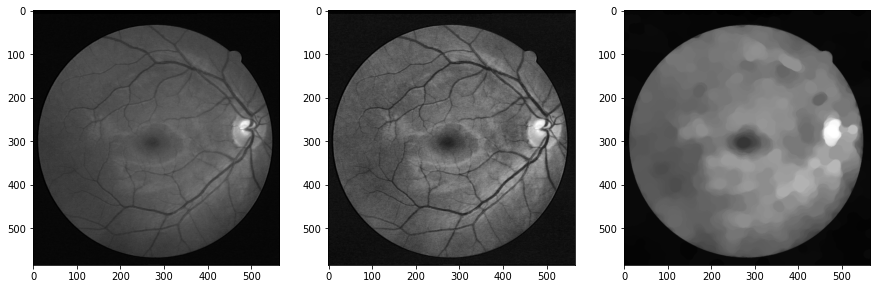

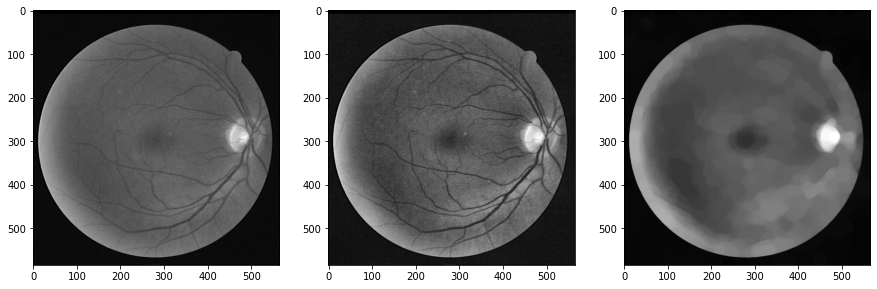

In [3]:
for i in range(1,11):
    preProcess(i)

In [4]:
def postProcess(i):
    image = cv2.imread('training/images/'+str(i)+'_training.tif')
    g = image[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_g_fundus = clahe.apply(g)
    R3 = alternateSequentialFiltering(contrast_g_fundus)
    f4 = cv2.subtract(R3, contrast_g_fundus)
    f5 = clahe.apply(f4)
    f6 = clahe.apply(f5)
    f7 = clahe.apply(f6)
    
    _, thresh = cv2.threshold(f7, 15, 255, cv2.THRESH_BINARY)  #mapping array 0 atau 255 (item putih)
    maskSmallContour = np.ones(f7.shape[:2], dtype="uint8") * 255 #mapping array bernilai 255 (utk masking)
    contoursSmall, _ = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) #
    for cnts in contoursSmall:
        if cv2.contourArea(cnts) <= 200: 
            cv2.drawContours(maskSmallContour, [cnts], 0, 0, -1)
    im = cv2.bitwise_and(f5, f5, mask=maskSmallContour)
    _, fin = cv2.threshold(im, 30, 255, cv2.THRESH_BINARY)

    plt.subplot(1,2,1)
    plt.imshow(im, cmap="gray")
    cv2.imwrite('./image/im/'+str(i)+'_bloodvessel.png', im)
    plt.subplot(1,2,2)
    plt.imshow(fin, cmap="gray")
    cv2.imwrite('./image/firstresult/'+str(i)+'_bloodvessel.png', fin)

d:\users\asus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\users\asus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


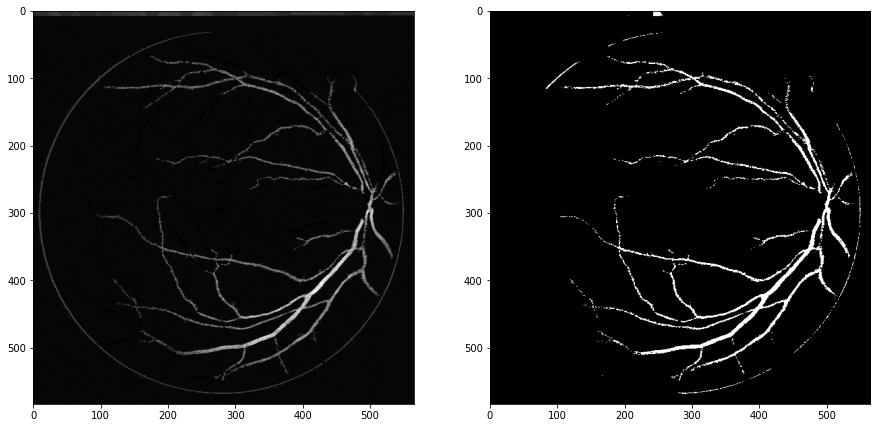

In [5]:
# postProcess(22)
for i in range(1,11):
    postProcess(i)

In [6]:
def removeBoarder(i):
    im = Image.open('training/mask/'+str(i)+'_training_mask.gif')
    im = im.convert('RGB')
    I = np.asarray(im)
    image = cv2.imread('image/firstresult/'+str(i)+'_bloodvessel.png')
    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(I, kernel, iterations=4)
    result = cv2.bitwise_and(erosion, image)
    
    plt.subplot(1,3,1)
    plt.imshow(image, cmap="gray")
    plt.subplot(1,3,2)
    plt.imshow(erosion, cmap="gray")
    plt.subplot(1,3,3)
    plt.imshow(result, cmap="gray")
    cv2.imwrite('image/lastresult/'+str(i)+'_bloodvessel.png', result)
    plt.show()

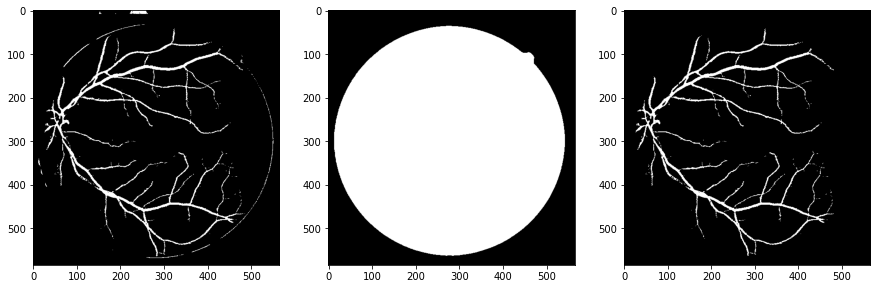

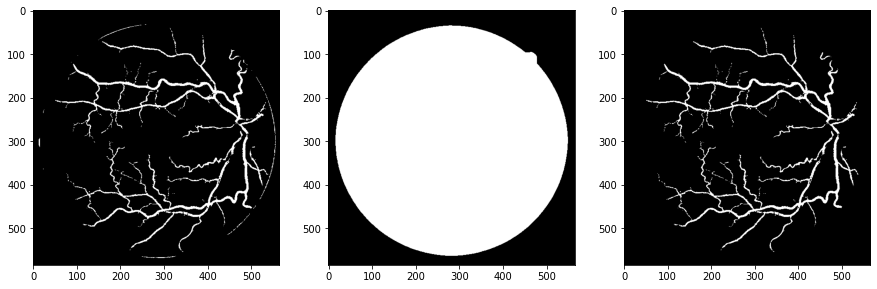

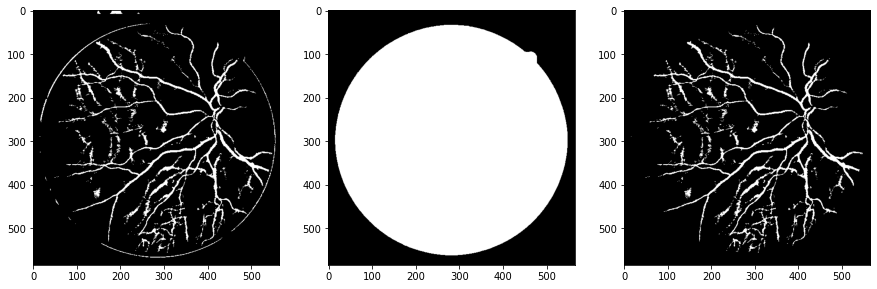

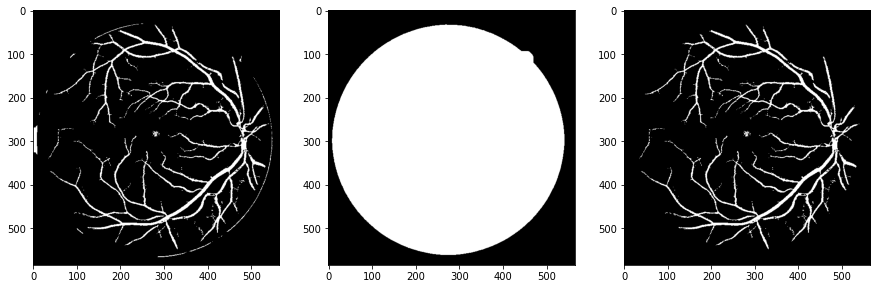

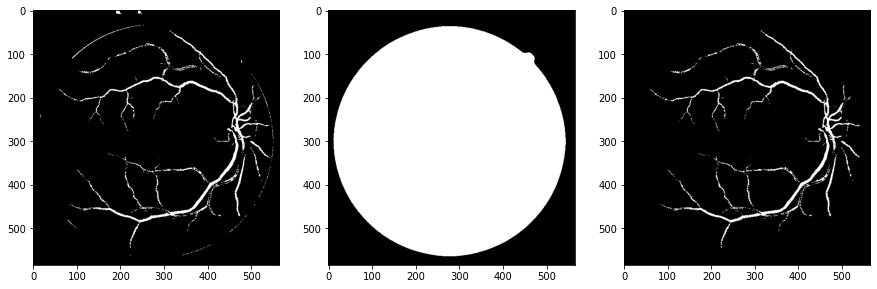

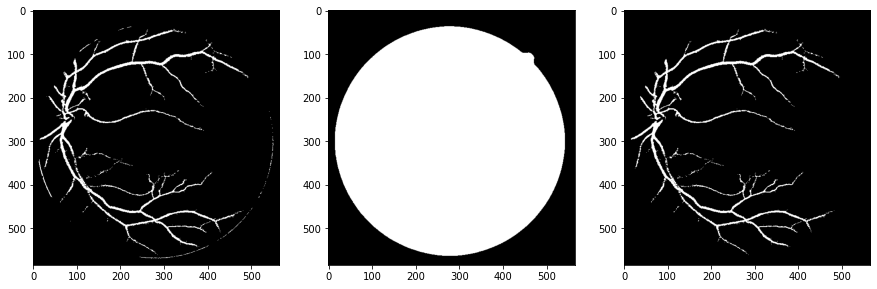

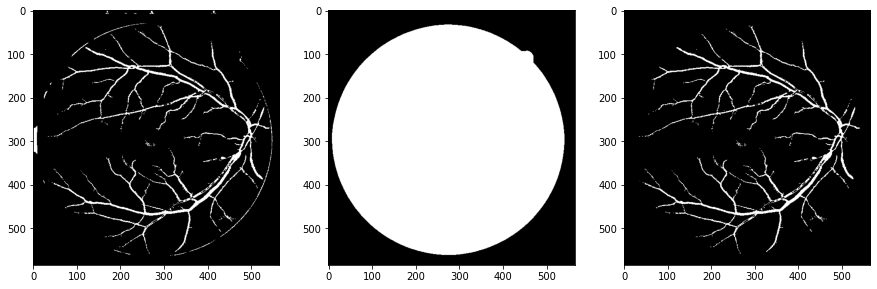

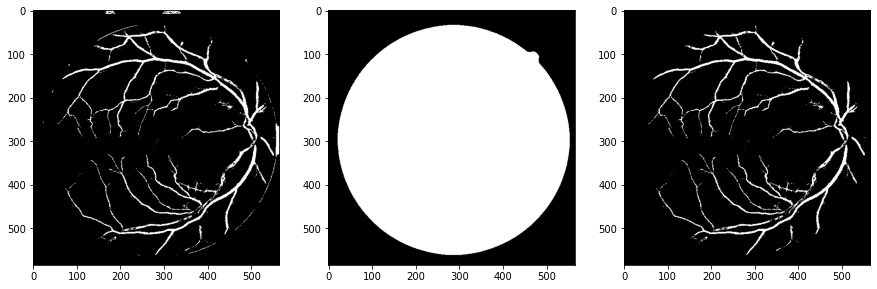

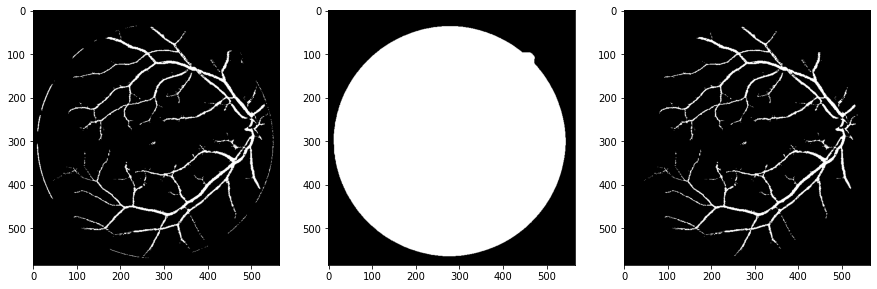

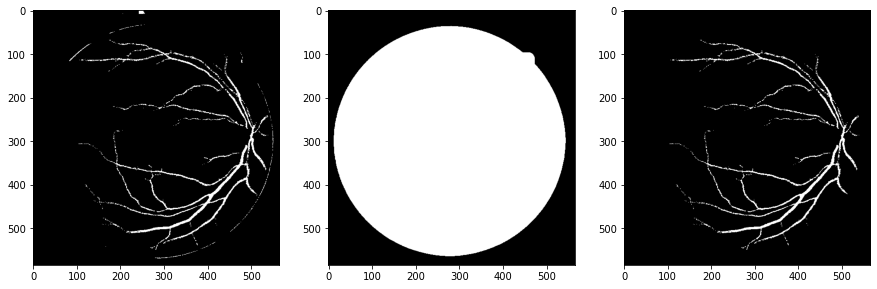

In [7]:
for i in range(1,11):
    removeBoarder(i)

In [8]:
def skeleton(i):
    image_input = cv2.imread('image/lastresult/'+str(i)+'_bloodvessel.png')
    kernel = np.ones((5, 5), np.uint8)
    out_test_ch = cv2.dilate(image_input,kernel,iterations = 3)
    out = skeletonize(out_test_ch)
    out = cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)
    test_labelized = label(out)
    test_depleted_bis = np.where(test_labelized > 1,0,test_labelized)
    plt.subplot(1,4,1)
    plt.imshow(image_input, cmap="gray")
    plt.subplot(1,4,2)
    cv2.imwrite('image/dilation-skeleton/'+str(i)+'_bloodvessel.png', out_test_ch)
    plt.imshow(out_test_ch, cmap="gray")
    plt.subplot(1,4,3)
    cv2.imwrite('image/skeleton/'+str(i)+'_bloodvessel.png', out)
    plt.imshow(out, cmap="gray")
    plt.subplot(1,4,4)
    plt.imshow(test_depleted_bis, cmap="gray")
    plt.imsave(fname='image/remove_region/'+str(i)+'_bloodvessel.png',arr=test_depleted_bis,cmap='gray', format='png')
    plt.show()

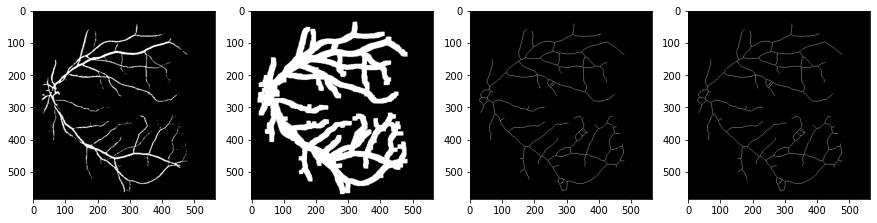

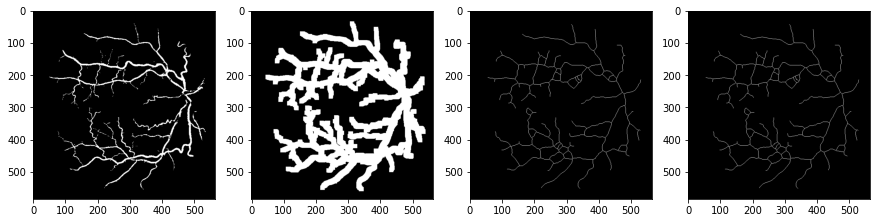

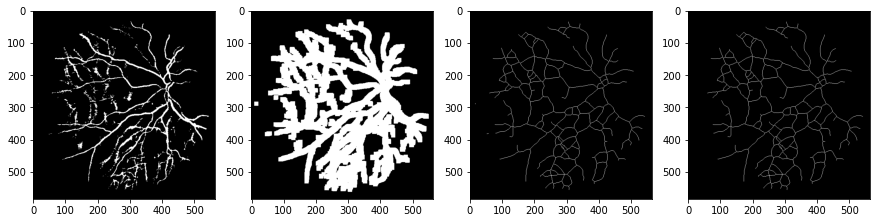

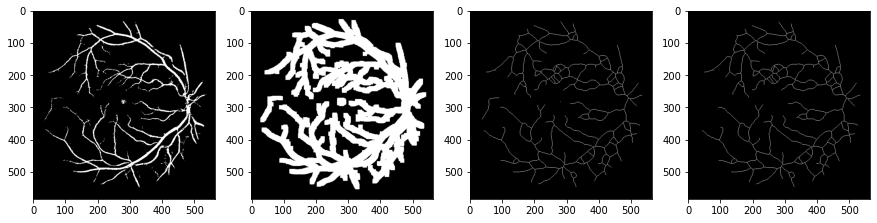

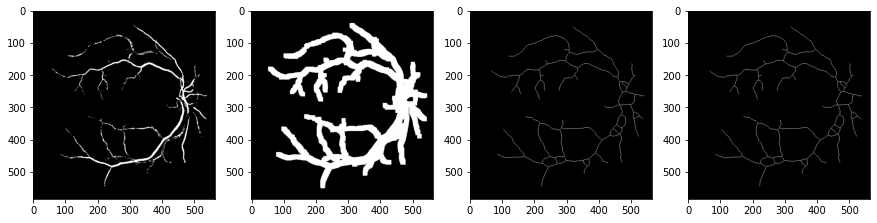

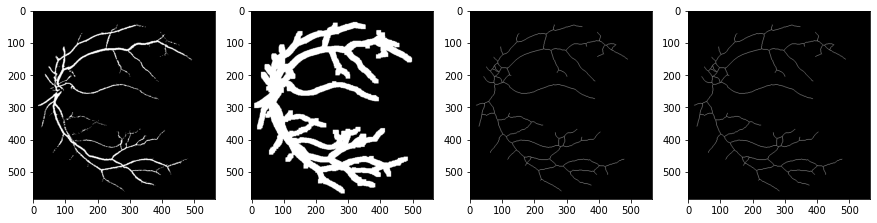

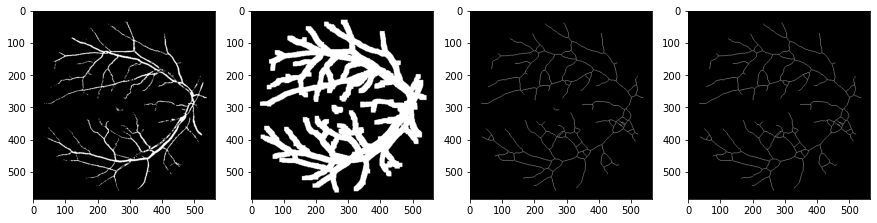

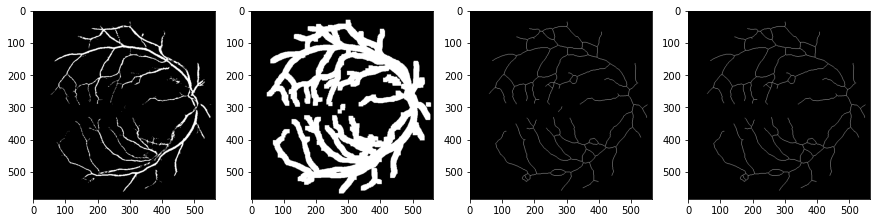

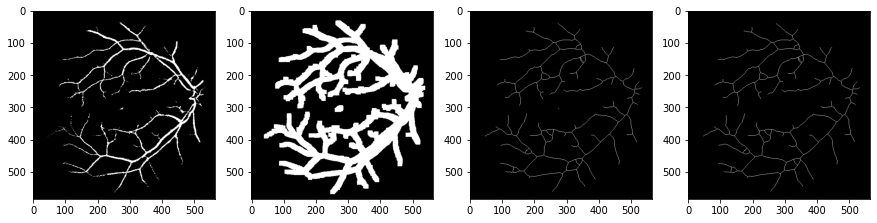

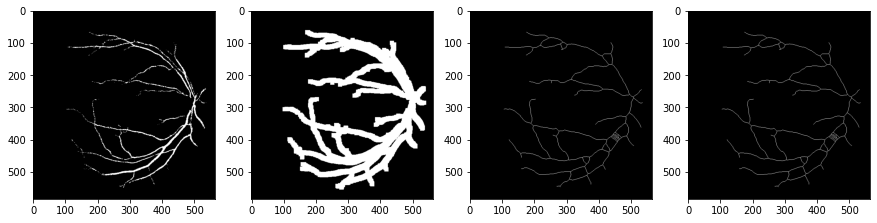

In [9]:
for i in range(1,11):
    skeleton(i)

In [10]:
def showPicture(i):
    predict = cv2.imread('image/lastresult/'+str(i)+'_bloodvessel.png')
    origin = cv2.imread('training/images/'+str(i)+'_training.tif')
    origin = cv2.cvtColor(origin, cv2.COLOR_BGR2RGB)
    im = Image.open('training/1st_manual/'+str(i)+'_manual1.gif')
    im = im.convert('RGB')
    label = np.asarray(im)
    plt.subplot(1,3,1)
    plt.imshow(origin), plt.title(f"image {i}", {"fontsize": 20})
    plt.subplot(1,3,2), plt.title(f"manual {i}", {"fontsize": 20})
    plt.imshow(label, cmap="gray")
    plt.subplot(1,3,3), plt.title(f"predict {i} ", {"fontsize": 20})
    plt.imshow(predict, cmap="gray")
    plt.show()

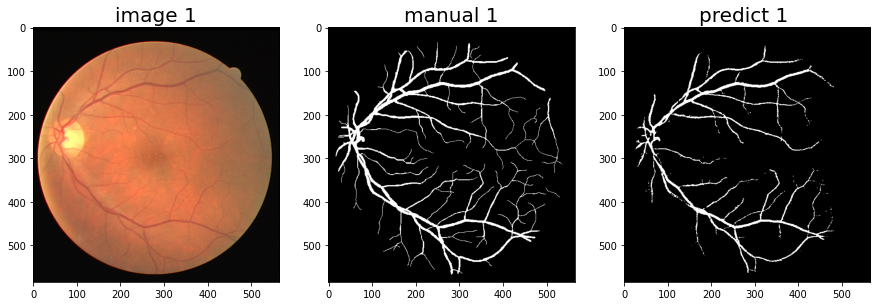

In [11]:
showPicture(1)

In [12]:
import seaborn as sns
sns.set(font_scale=1.4)

def plot_matrix(cm, classes, title):
    ax = sns.heatmap(cm, cmap="Greens", annot=True, xticklabels=classes, yticklabels=classes, cbar=False,fmt='d')
    ax.set(title=title, xlabel="predicted label", ylabel="true label")
    
tn, fp, fn, tp = 0, 0, 0, 0
values = []

def accuracy(i):
    global tn, fp, fn, tp
    predict = cv2.imread('image/lastresult/'+str(i)+'_bloodvessel.png')
    im = Image.open('training/1st_manual/'+str(i)+'_manual1.gif')
    title = str(i)+'_training.tif'
    im = im.convert('RGB')
    I = np.asarray(im)
    for i in range(predict.shape[0]):                 
        for j in range(predict.shape[1]):
            if(predict[i,j].all()==I[i,j].all()):
                if(predict[i,j].all()==1):
                    tp+=1
                else:
                    tn+=1
            else:
                if(predict[i,j].all()==1):
                    fp+=1
                else:
                    fn+=1
    cm = np.array([
        [tp,fn],
        [fp,tn]
    ])
    classes = ['1', '0']

    plot_matrix(cm, classes, title)
    
    print(cm)
    
    total = tp + fp + fn + tn
    accuracy = ((tp + tn) / total)*100
    accuracy = round(accuracy,3)
    values.append(accuracy)
    print('current accuracy '+str(accuracy))
    plt.show()

[[ 14828   9830]
 [  1312 303990]]
current accuracy 96.623


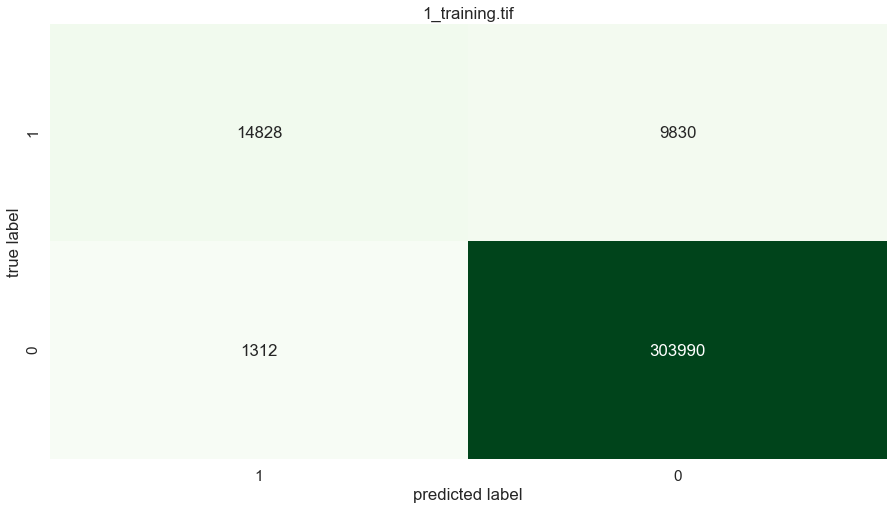

[[ 31265  23202]
 [  2404 603049]]
current accuracy 96.12


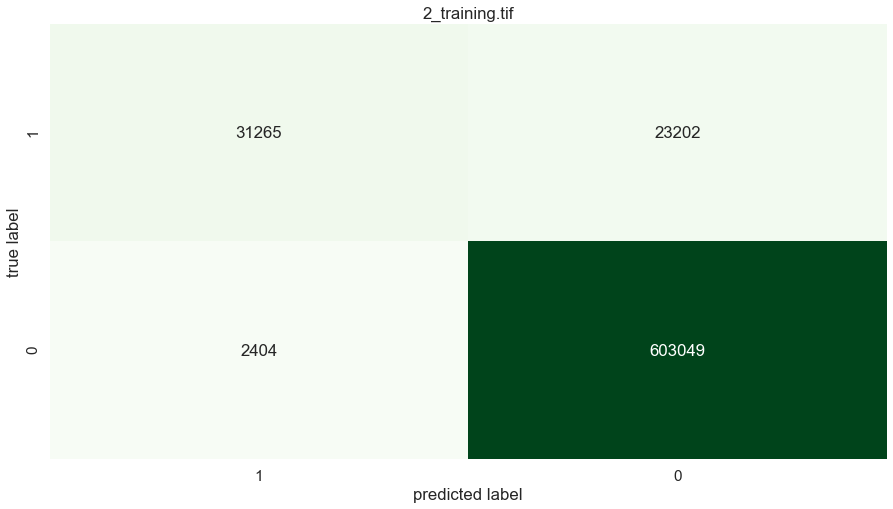

[[ 44624  31566]
 [ 11961 901729]]
current accuracy 95.603


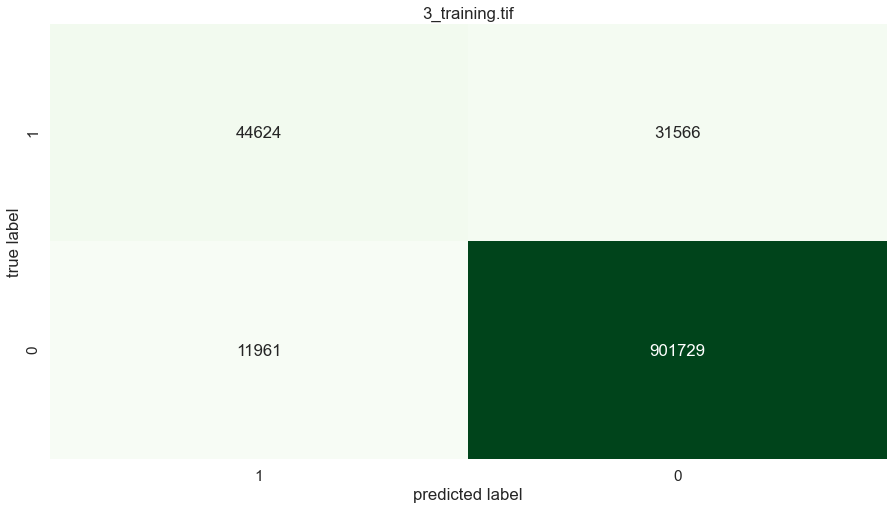

[[  66051   48368]
 [  13384 1192037]]
current accuracy 95.321


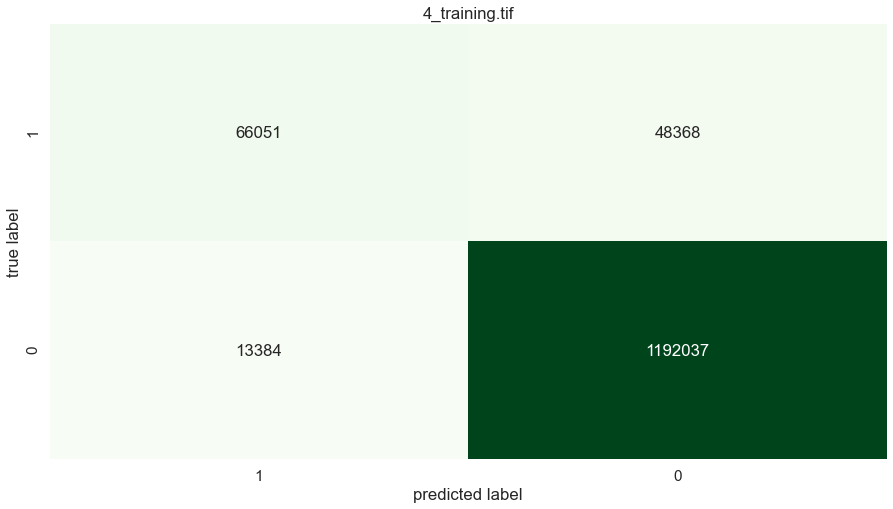

[[  76882   69206]
 [  13766 1489946]]
current accuracy 94.971


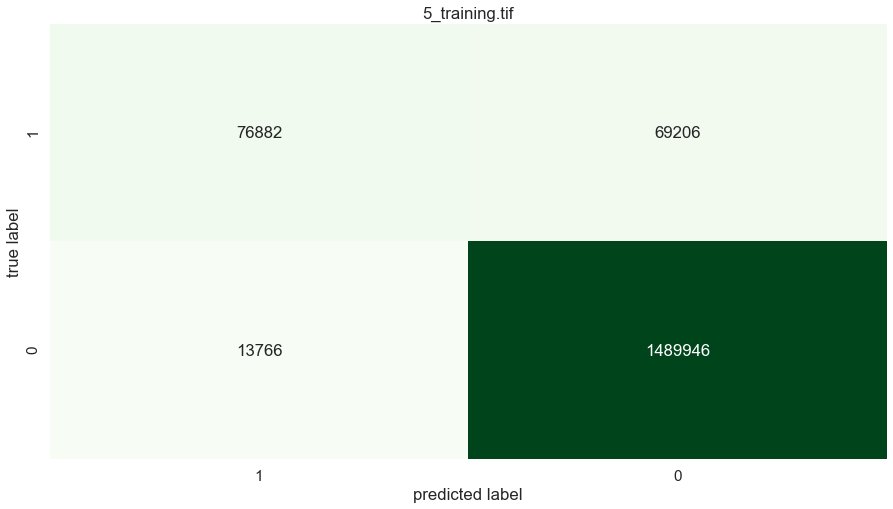

[[  90906   82755]
 [  14609 1791490]]
current accuracy 95.082


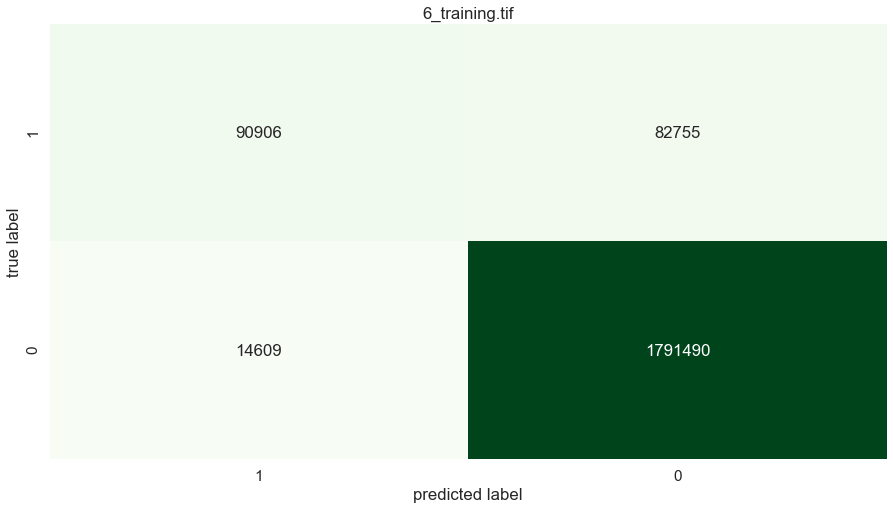

[[ 106663   96071]
 [  15933 2091053]]
current accuracy 95.151


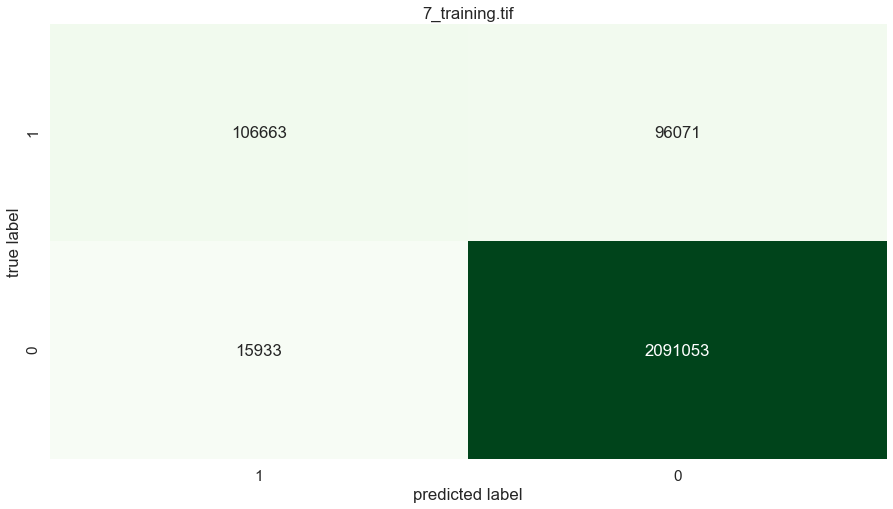

[[ 124175  110787]
 [  17160 2387558]]
current accuracy 95.153


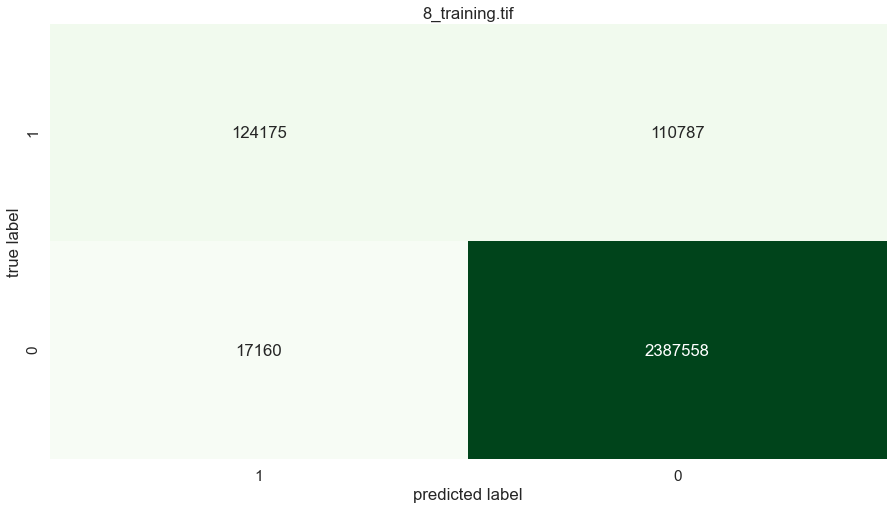

[[ 139616  123097]
 [  18859 2688068]]
current accuracy 95.22


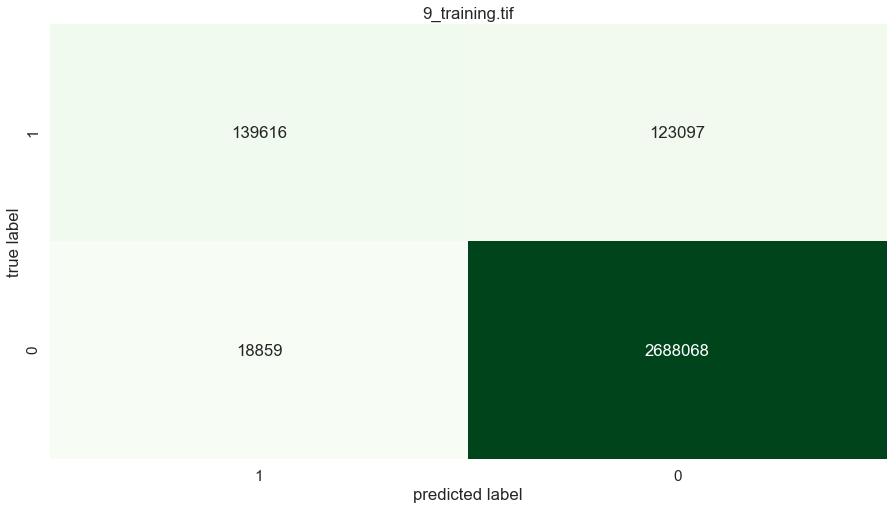

[[ 149712  138885]
 [  19596 2991407]]
current accuracy 95.197


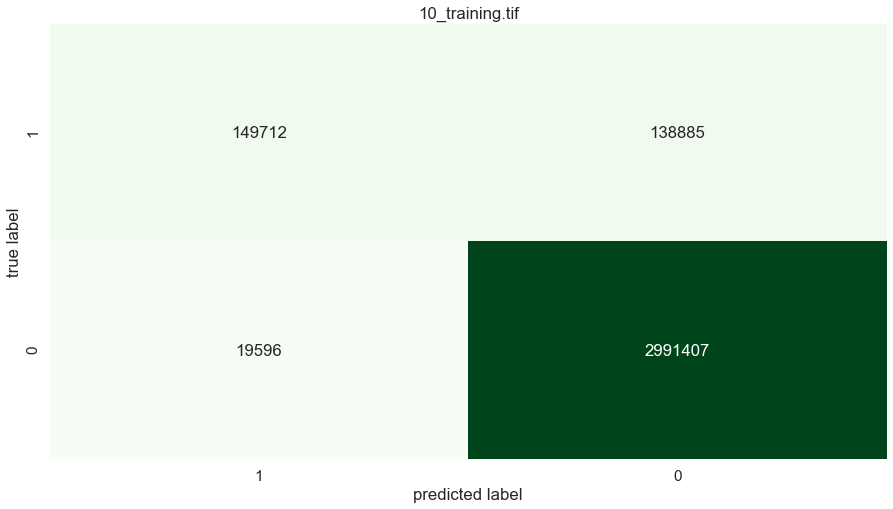

rata-rata 95.4441


In [13]:
for i in range(1, 11):
    accuracy(i)
rata=sum(values)/len(values)
print("rata-rata",rata)

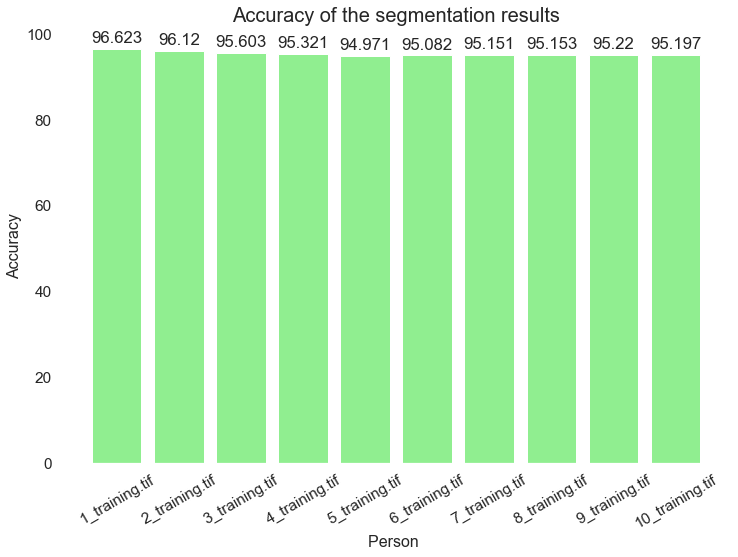

In [14]:
labels = ['1_training.tif', '2_training.tif', '3_training.tif','4_training.tif','5_training.tif', '6_training.tif', '7_training.tif','8_training.tif','9_training.tif','10_training.tif']
x = np.arange(len(labels))

plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(figsize=(12, 8))
graph = ax.bar(x, values, width=0.8, color='lightgreen')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(graph)
plt.xlabel('Person ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy of the segmentation results',fontsize=20)
plt.show()

In [15]:
bifurcations_list = list()
crossover_list = list()

bifurcations = [
    
    [[1,0,1],
     [0,1,0],
     [0,1,0]],
    [[1,0,1],
     [0,1,0],
     [1,0,0]],
    [[1,0,0],
     [0,1,1],
     [1,0,0]],

     [[0,0,1],
      [1,1,0],
      [0,1,0]],

     [[1,0,0],
      [0,1,1],
      [0,1,0]],

     [[0,1,0],
      [0,1,1],
      [0,1,0]],

      [[0,1,0],
       [1,1,0],
       [0,0,1]],

     [[1,0,0],
      [0,1,1],
      [0,1,0]]
]
crossover  = [
    [[0,0,1,0,0],
     [0,0,1,0,0],
     [1,1,1,1,1],
     [0,0,1,0,0],
     [0,0,1,0,0]],
    
    [[1,0,0,0,1],
     [0,1,0,1,0],
     [0,0,1,0,0],
     [0,1,0,1,0],
     [1,0,0,0,1]],
    
    [[0,0,1,0,0],
     [1,0,1,0,0],
     [0,1,1,1,0],
     [0,0,1,0,1],
     [0,0,1,0,0]],
    
    [[1,0,1,0,0],
     [1,0,1,0,0],
     [0,1,1,1,0],
     [0,0,1,0,1],
     [0,0,1,0,1]],
    
    [[1,0,0,0,1],
     [0,1,0,1,0],
     [0,0,1,0,0],
     [0,1,0,1,1],
     [0,1,0,0,0]],

]

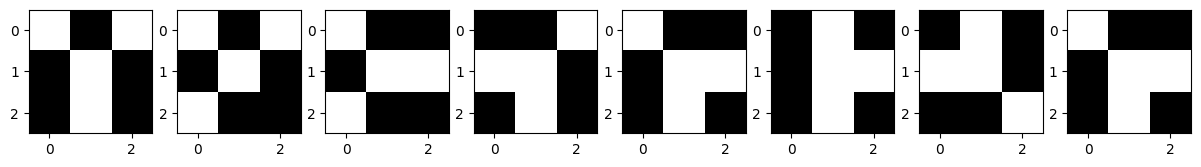

In [16]:
plt.rcdefaults()
fig,ax = plt.subplots(1,8,figsize=(15,3))

for i, idx in enumerate(bifurcations):
  ax[i].imshow(bifurcations[i], cmap = 'gray')

In [17]:
for i in range(4):
    for j in  range(len(bifurcations)):
        bifurcations_list.append(np.rot90(bifurcations[j],i))


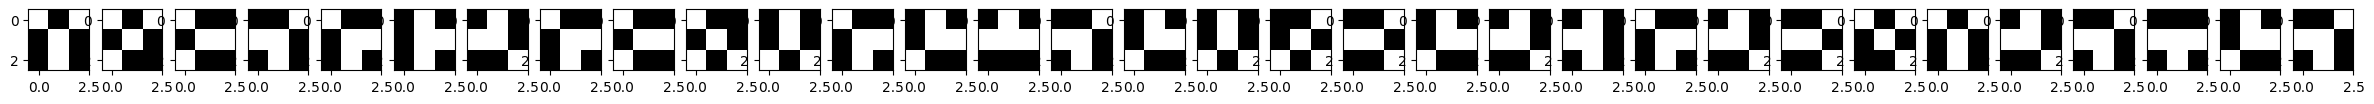

In [18]:
fig,ax = plt.subplots(1,len(bifurcations_list),figsize=(30,3))

for i, idx in enumerate(bifurcations_list):
  ax[i].imshow(bifurcations_list[i], cmap = 'gray')

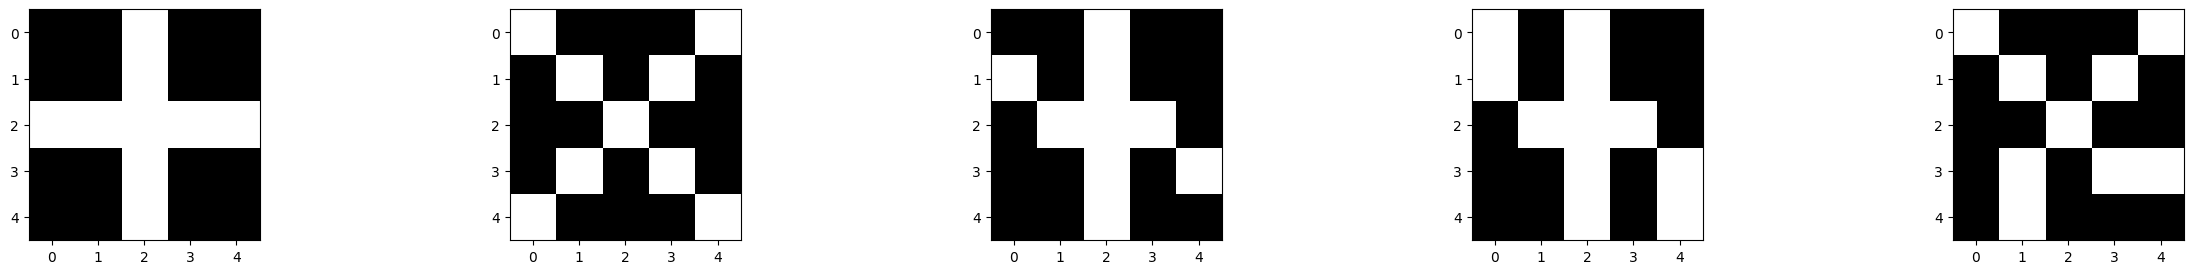

In [19]:
fig,ax = plt.subplots(1,len(crossover),figsize=(30,3))

for i, idx in enumerate(crossover):
  ax[i].imshow(crossover[i], cmap = 'gray')

In [20]:
crossover_list.append(crossover[0])
crossover_list.append(crossover[1])
for i in range(2):
    for j in  range(len(crossover)):
        if j != 0 and j!=1:
            crossover_list.append(np.rot90(crossover[j],i))

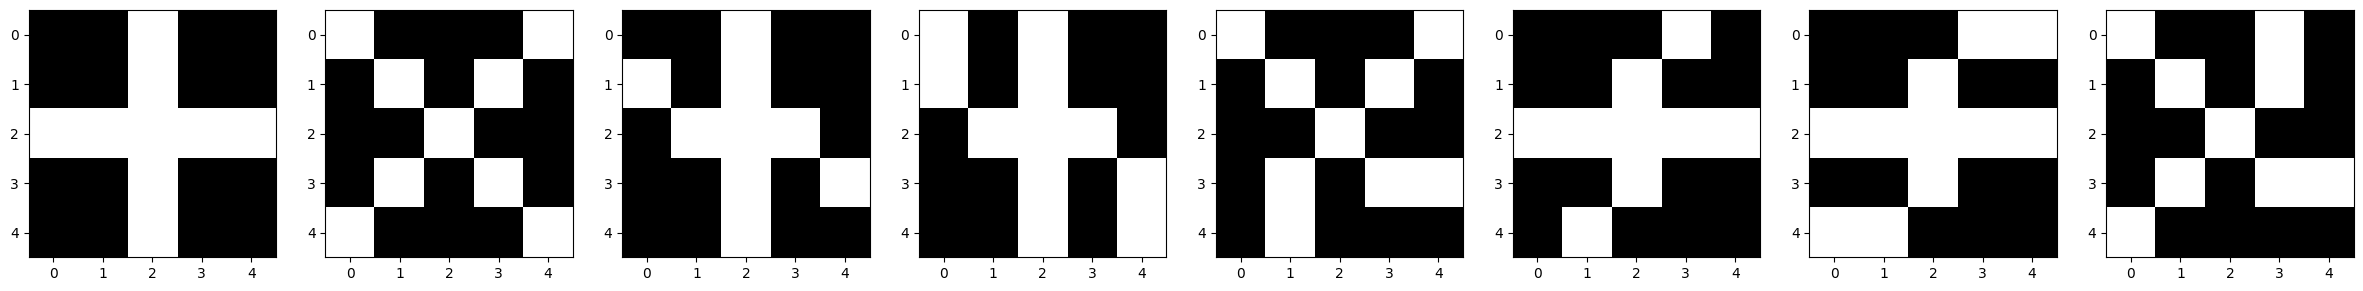

In [21]:
fig,ax = plt.subplots(1,len(crossover_list),figsize=(30,10))

for i, idx in enumerate(crossover_list):
  ax[i].imshow(crossover_list[i], cmap = 'gray')

In [22]:
def detection(i,furcations_list):
    img = cv2.imread('image/remove_region/'+str(i)+'_bloodvessel.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    arr = np.asarray(img)
    result = np.zeros(arr.shape)
    for fur in furcations_list:
        result = result + ndi.binary_hit_or_miss((arr), fur).astype(np.int)
    result=morphology.dilation(result)

    # label image regions
    label_image = label(result)

    return regionprops(label_image),img

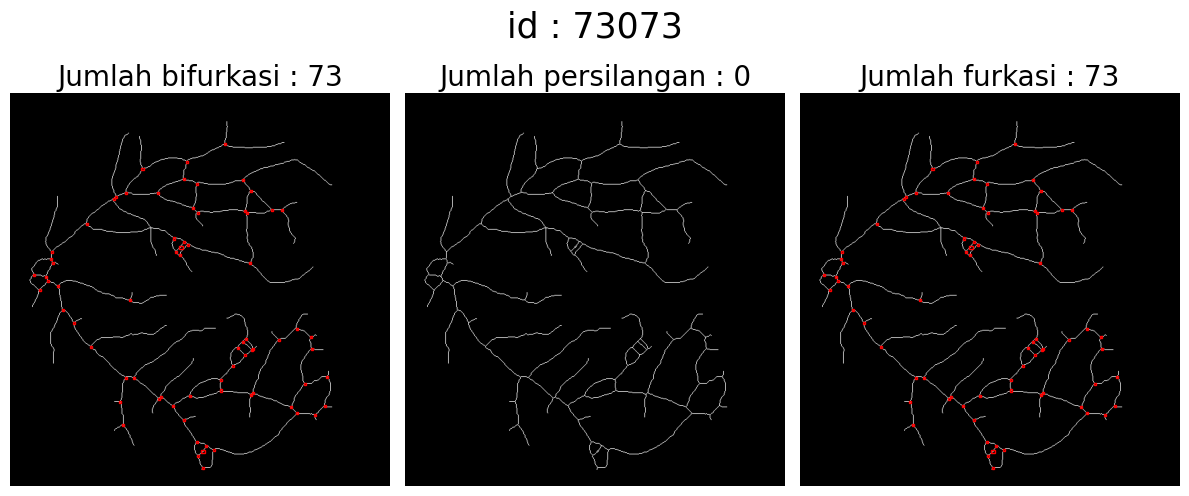

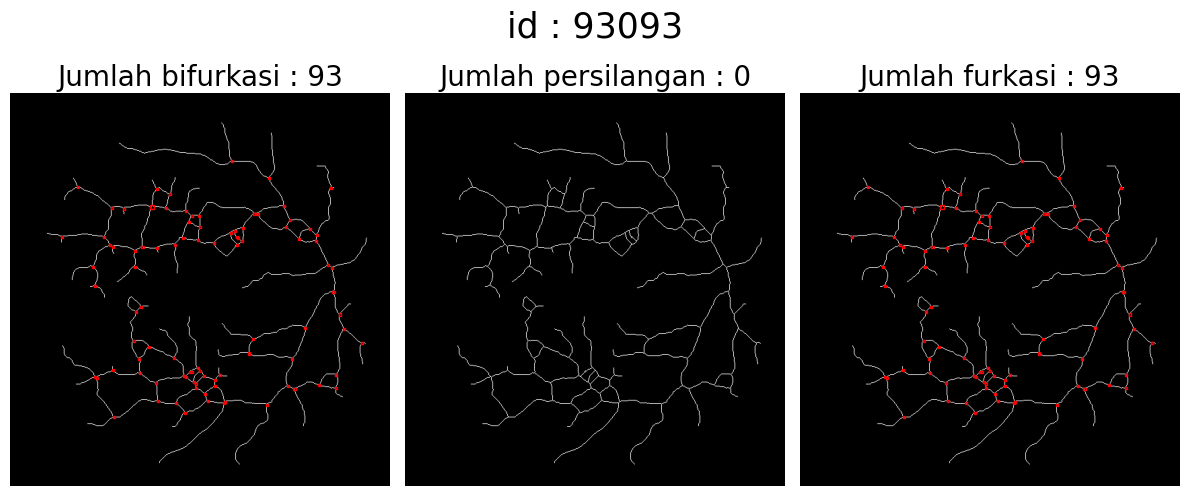

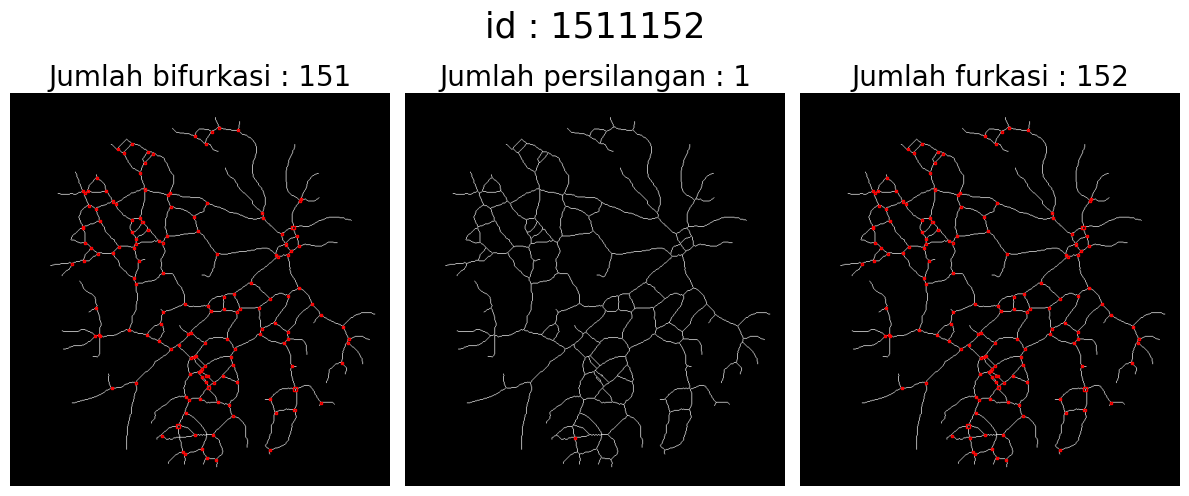

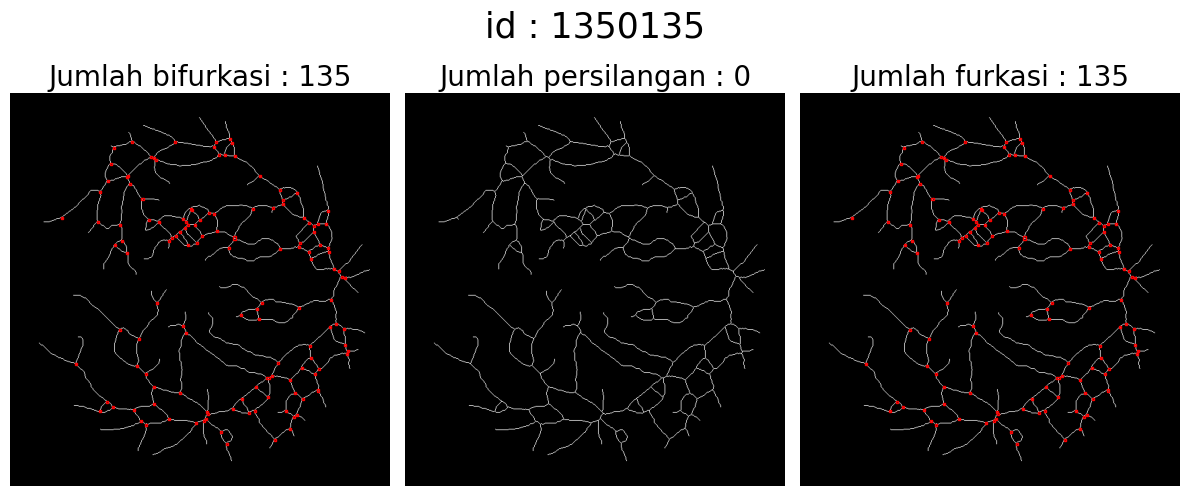

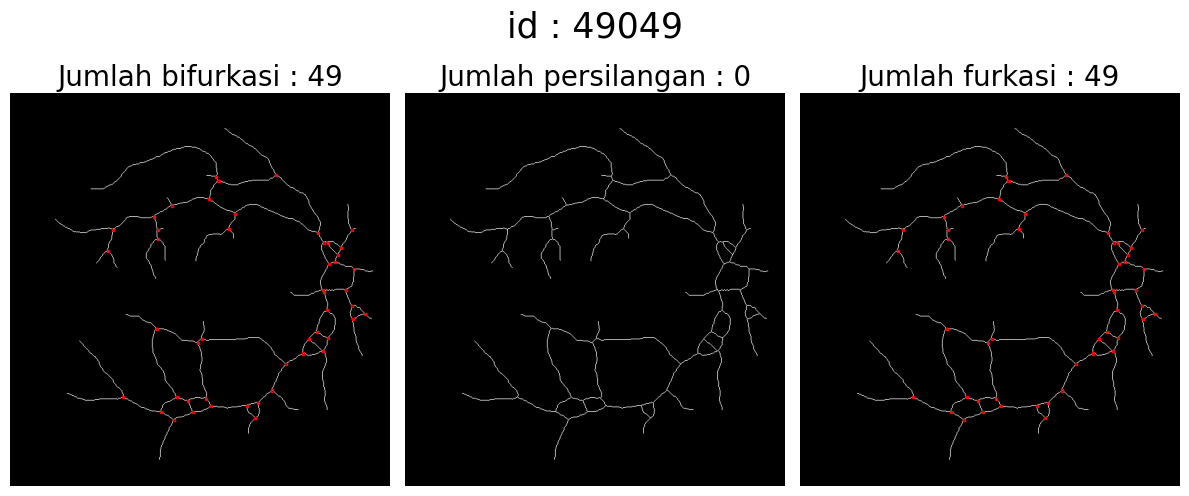

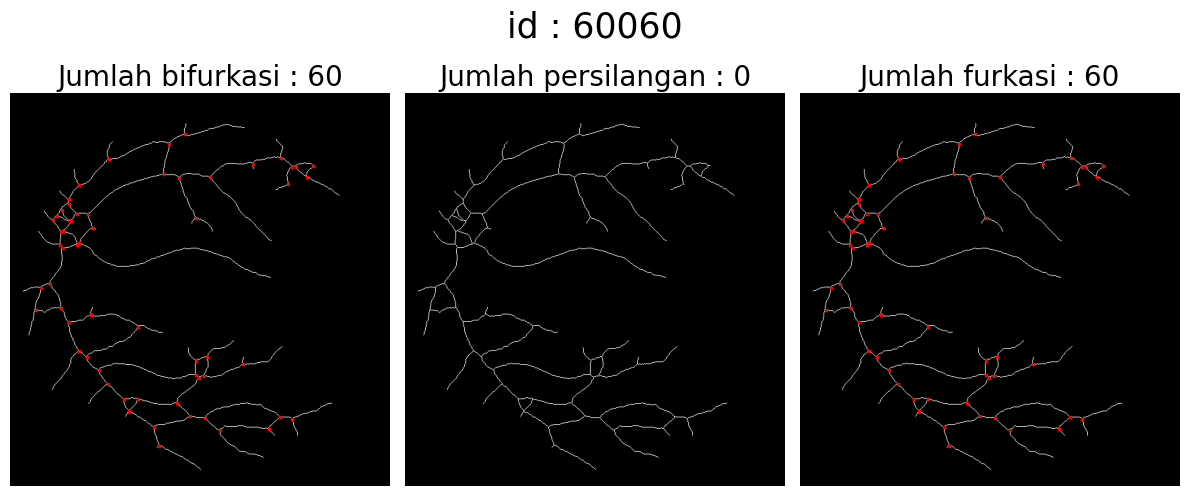

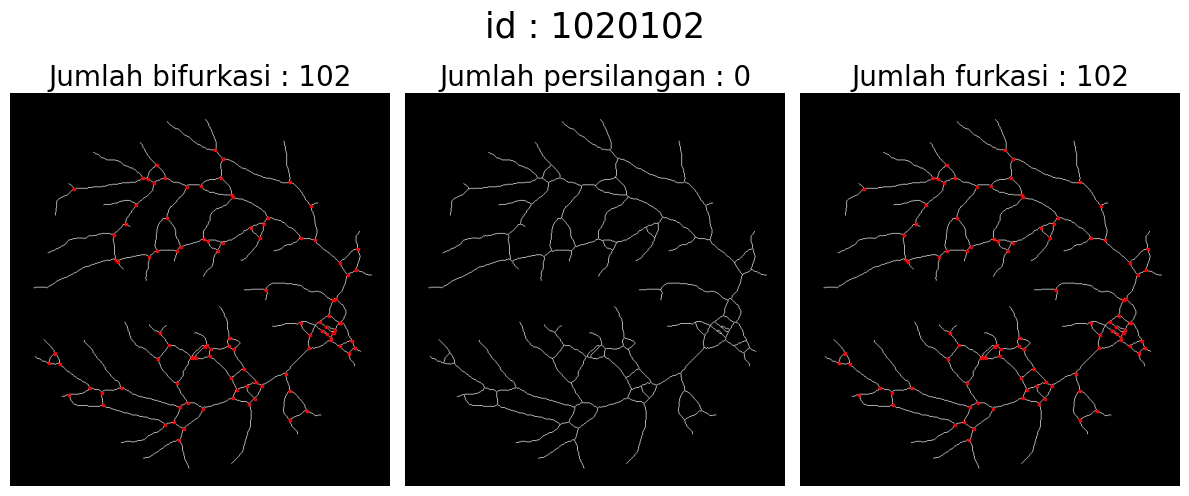

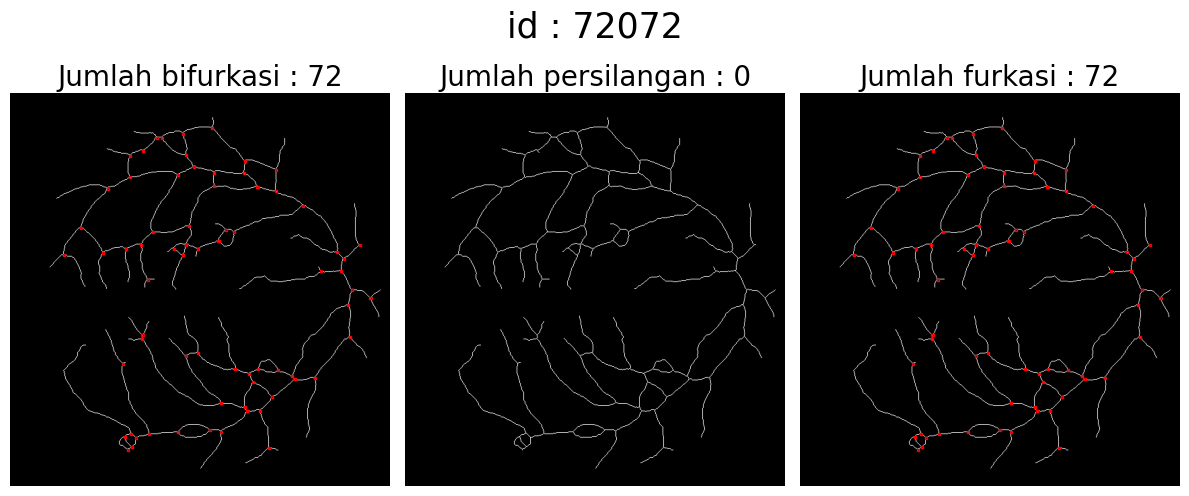

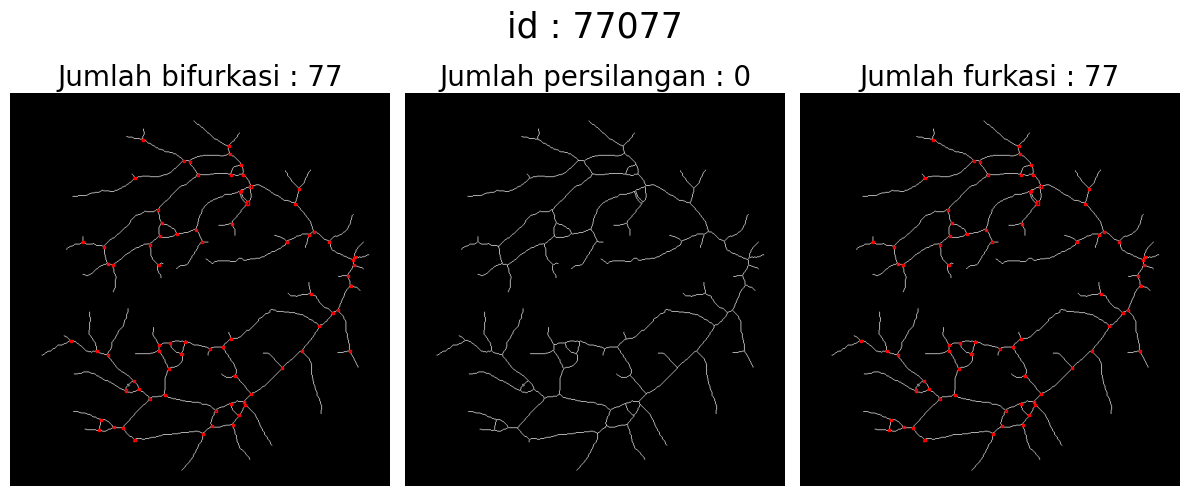

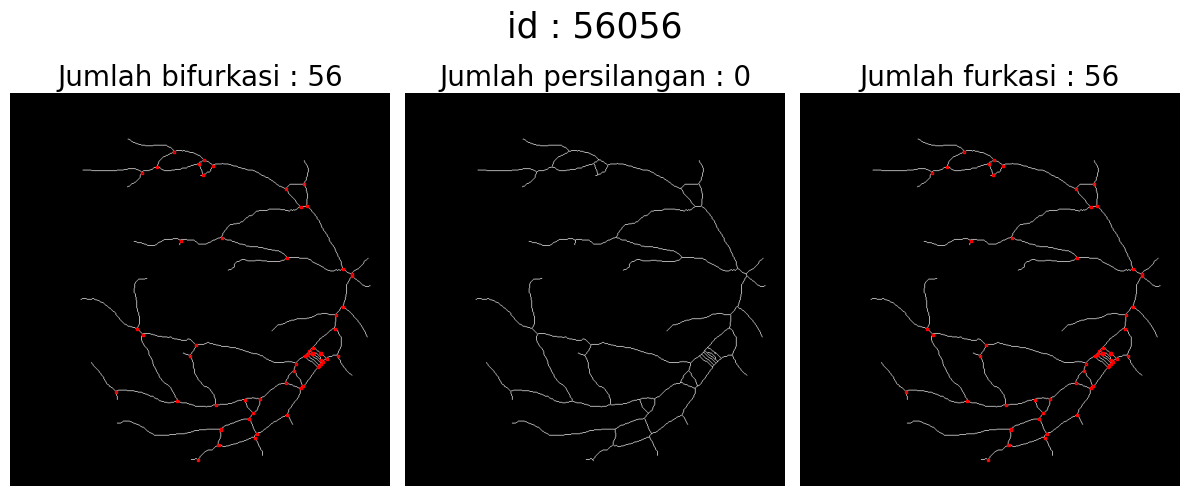

In [23]:
for i in range(1, 11):
    bif_res,skel_img = detection(i,bifurcations_list)
    cross_res,_ = detection(i,crossover_list)
    fig, ax = plt.subplots(1,3,figsize=(12, 8))
    combine = bif_res + cross_res
    directory = 'image/bifur_detect/'+str(i)+'_bloodvessel'
    for index,region in enumerate(bif_res):
        # take regions with large enough areas
        if region.area >= 1:
            # draw rectangle
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=1)
            ax[0].add_patch(rect)
    directory = 'image/cross_detect/'+str(i)+'_bloodvessel'
    for index,region in enumerate(cross_res):
        # take regions with large enough areas
        if region.area >= 1:
            # draw rectangle
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=1)
            ax[1].add_patch(rect)
    for index,region in enumerate(combine):
        # take regions with large enough areas
        if region.area >= 1:
            # draw rectangle
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=1)
            ax[2].add_patch(rect)
    ax[0].imshow(skel_img, cmap='gray')
    ax[0].set_title('Jumlah bifurkasi : '+str(len(bif_res)),fontsize=20)
    ax[0].set_axis_off()
    
    
    ax[1].imshow(skel_img, cmap='gray')
    ax[1].set_title('Jumlah persilangan : '+str(len(cross_res)),fontsize=20)
    ax[1].set_axis_off()
    
    ax[2].imshow(skel_img, cmap='gray')
    ax[2].set_title('Jumlah furkasi : '+str(len(combine)),fontsize=20)
    ax[2].set_axis_off()
    
    plt.suptitle('id : '+str(len(bif_res))+str(len(cross_res))+str(len(combine)),fontsize=25, y=0.82)
    plt.tight_layout()
    
    plt.show()

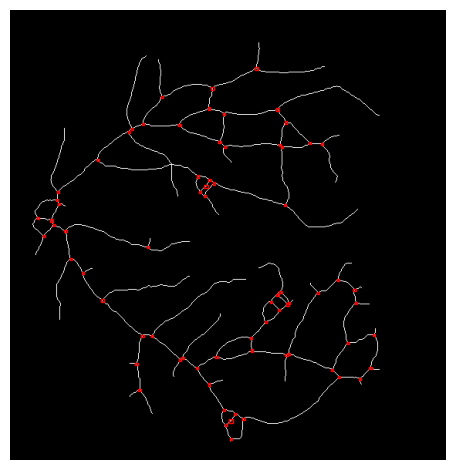

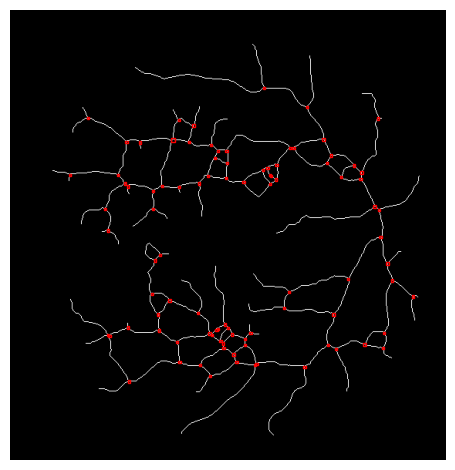

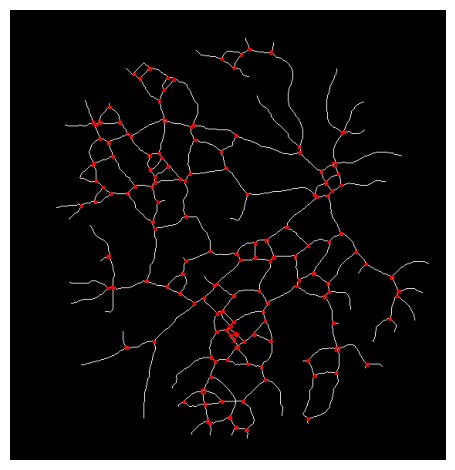

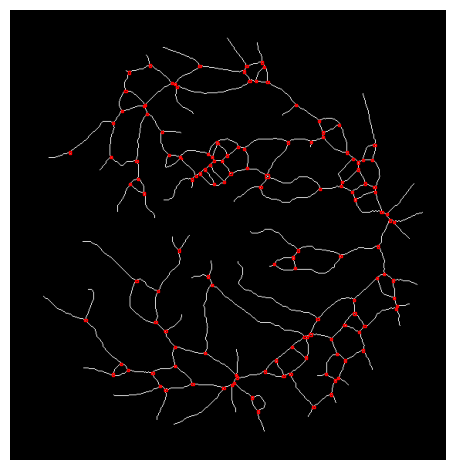

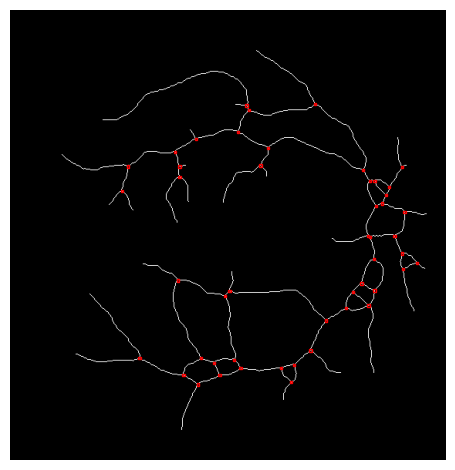

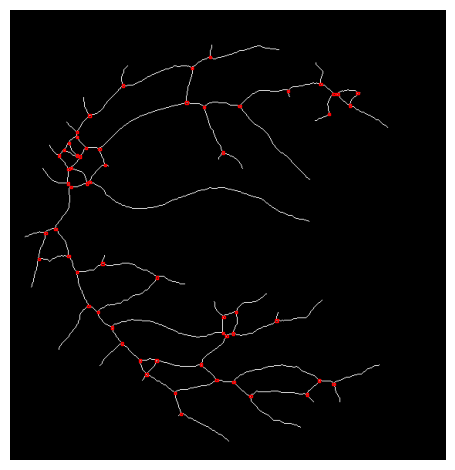

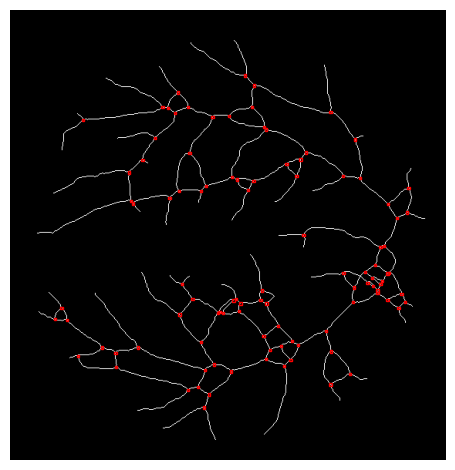

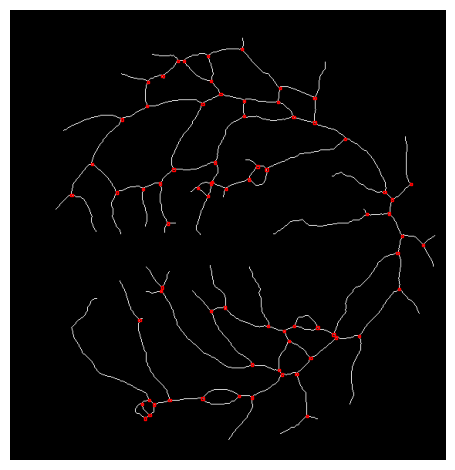

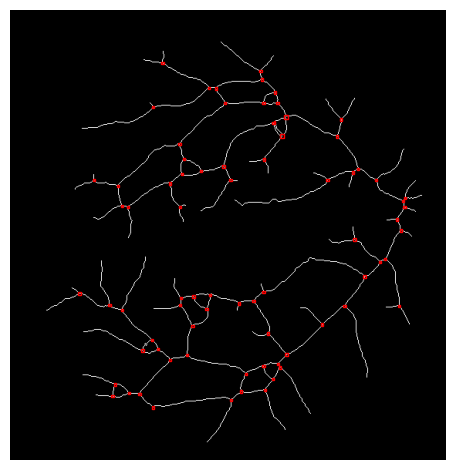

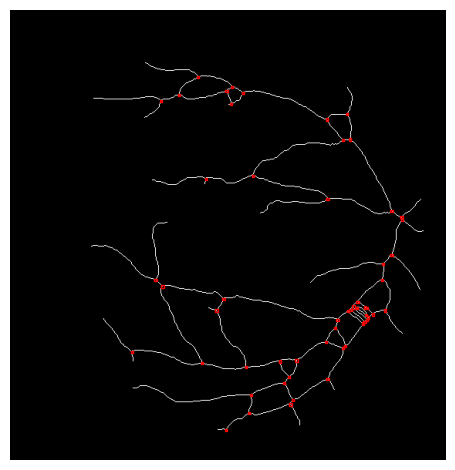

In [24]:
for i in range(1, 11):
    bif_res,skel_img = detection(i,bifurcations_list)
    cross_res,_ = detection(i,crossover_list)
    combine = bif_res + cross_res
    fig, ax = plt.subplots() 
    for index,region in enumerate(combine):
        if region.area >= 1:
                # draw rectangle around segmented coins
                minr, minc, maxr, maxc = region.bbox
                rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                          fill=False, edgecolor='red', linewidth=1)
                ax.add_patch(rect)
    ax.imshow(skel_img, cmap='gray')
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig('image/detected/'+str(i)+'_bloodvessel.png', bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()